In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
import tensorflow as tf
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers.legacy import Adam 

PARQUET_PATH = "New_60s_bucket.parquet"
WINDOW       = 30
ROLL_STEP    = 30
BATCH_SIZE   = 128
SCALE_FACTOR = 1_000.0
feature_cols = [
    "log_ret_mean", "log_ret_std", "log_ret_sum",
    "abs_volatility", "spread", "imbalance",
    "depth_ratio", "rv_rolling", "mom_rolling"
]
target_col = "realized_volatility"
tf.random.set_seed(3888)

stock_hyperparams = {
    50200: {"LSTM_UNITS": [64],      "DROPOUT": 0.25, "EPOCHS": 60,"TUNE_EPOCHS": 10, "LEARNING_RATE": 1e-3, "ALPHA_FINE_TUNE": 0.30},
    104919:{"LSTM_UNITS": [64],      "DROPOUT": 0.25, "EPOCHS": 60,"TUNE_EPOCHS": 10, "LEARNING_RATE": 1e-3, "ALPHA_FINE_TUNE": 0.30},
    "default": {"LSTM_UNITS": [64],  "DROPOUT": 0.30, "EPOCHS": 60,"TUNE_EPOCHS": 10, "LEARNING_RATE": 1e-3, "ALPHA_FINE_TUNE": 0.30}
}

df = pd.read_parquet(PARQUET_PATH)
df["date"] = pd.to_datetime(df["date"])
df["day_of_week"] = df["date"].dt.dayofweek + 1
df["week"] = df["date"].dt.isocalendar().week


Processing stock:   0%|          | 0/10 [00:00<?, ?it/s]

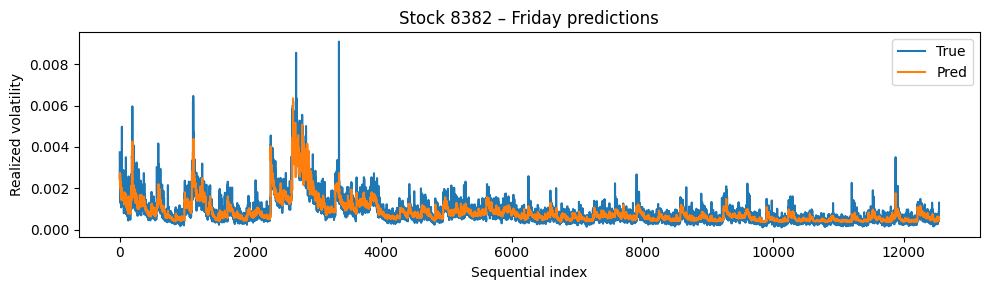

Processing stock:  10%|█         | 1/10 [09:59<1:29:53, 599.28s/it]

Stock 8382 total R²: 0.7985


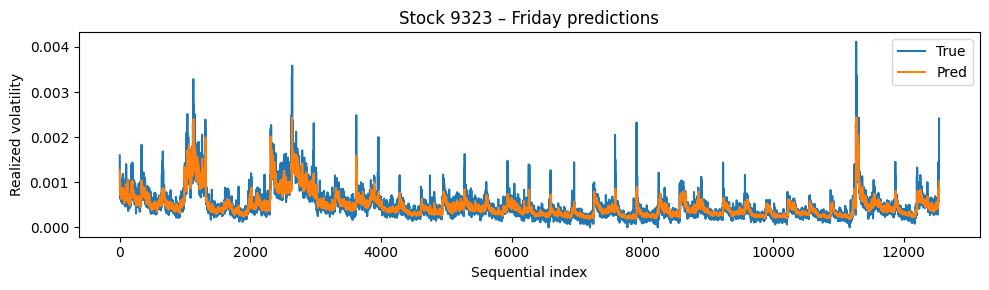

Processing stock:  20%|██        | 2/10 [19:55<1:19:40, 597.61s/it]

Stock 9323 total R²: 0.8053


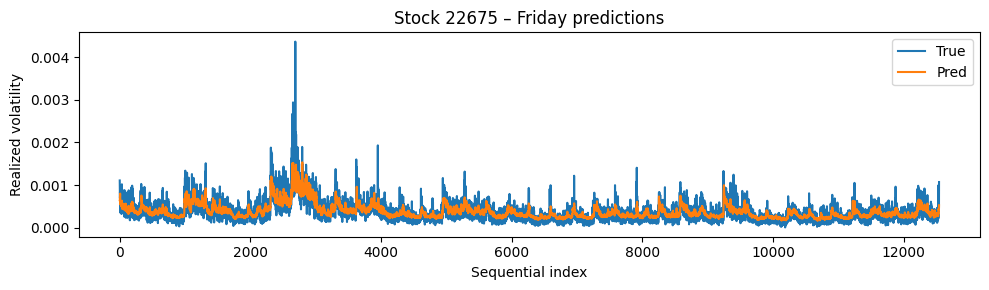

Processing stock:  30%|███       | 3/10 [29:49<1:09:31, 595.94s/it]

Stock 22675 total R²: 0.6348


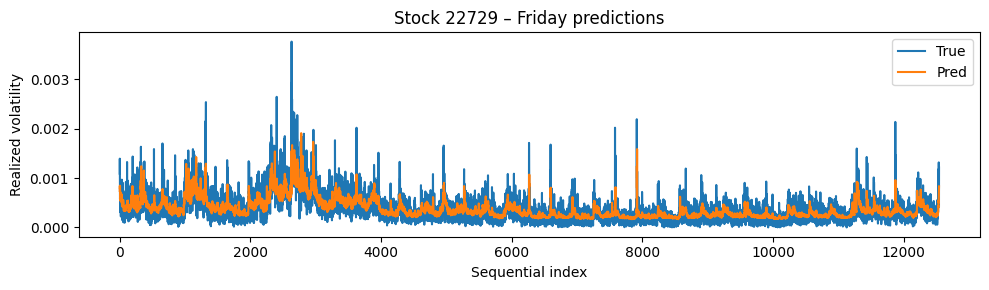

Processing stock:  40%|████      | 4/10 [39:31<59:03, 590.54s/it]  

Stock 22729 total R²: 0.5759


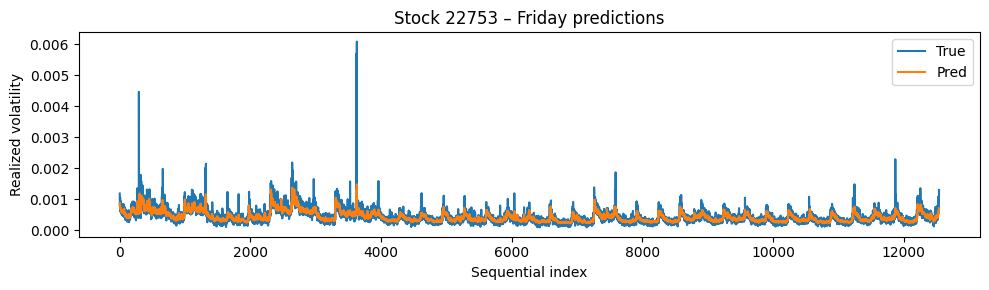

Processing stock:  50%|█████     | 5/10 [49:57<50:15, 603.19s/it]

Stock 22753 total R²: 0.6542


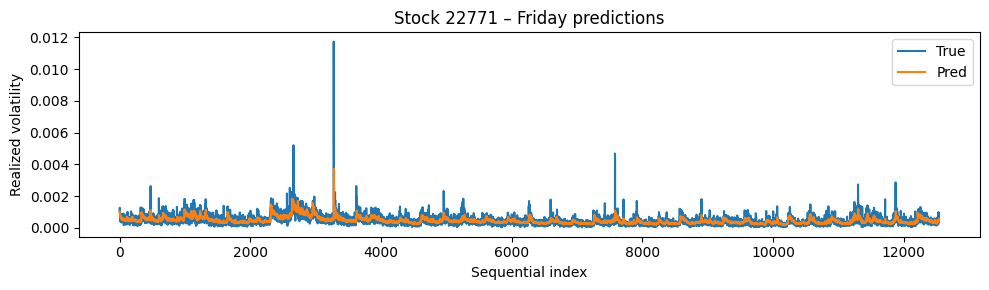

Processing stock:  60%|██████    | 6/10 [1:00:21<40:40, 610.24s/it]

Stock 22771 total R²: 0.4814


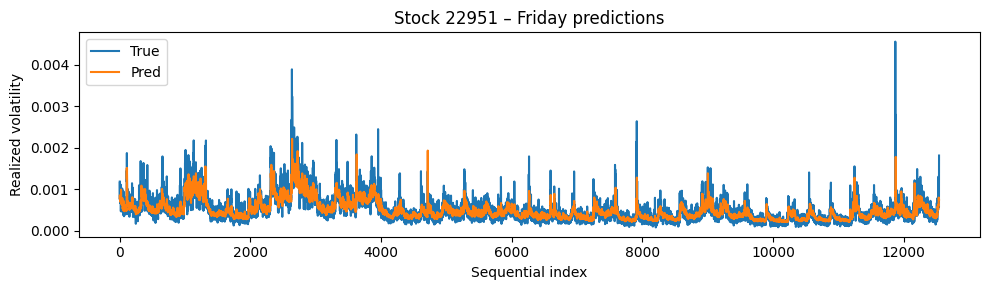

Processing stock:  70%|███████   | 7/10 [1:10:32<30:31, 610.63s/it]

Stock 22951 total R²: 0.7039


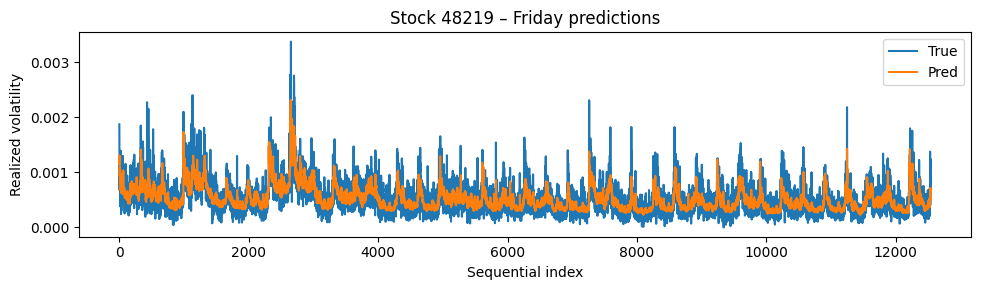

Processing stock:  80%|████████  | 8/10 [1:21:13<20:40, 620.15s/it]

Stock 48219 total R²: 0.5530


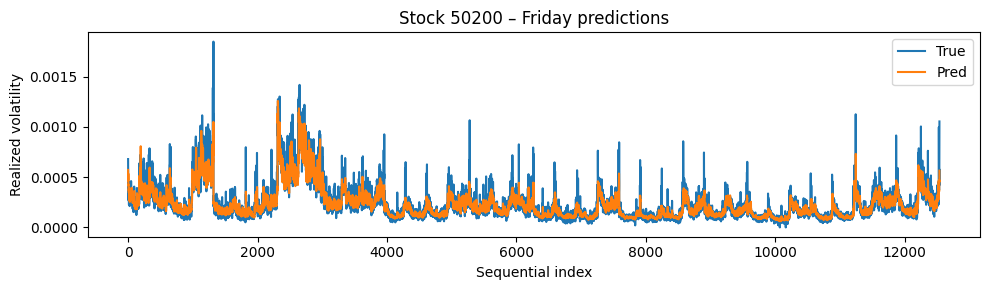

Processing stock:  90%|█████████ | 9/10 [1:31:50<10:25, 625.39s/it]

Stock 50200 total R²: 0.8399


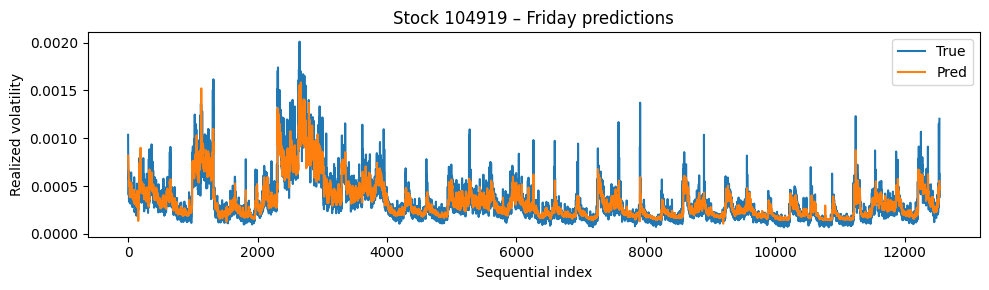

Processing stock: 100%|██████████| 10/10 [1:42:28<00:00, 614.87s/it]

Stock 104919 total R²: 0.8519
==== Overall performance ====
Overall R²: 0.7722


In [ ]:

def median_absolute_error(t, p):
    return np.median(np.abs(t - p))

def mape(t, p):
    t = np.clip(t, 1e-8, None)
    return np.mean(np.abs((t - p) / t)) * 100

def smape(t, p):
    denom = np.clip(np.abs(t) + np.abs(p), 1e-8, None)
    return np.mean(2*np.abs(p - t) / denom) * 100

def qlike(t, p):
    t = np.clip(t, 1e-8, None)
    p = np.clip(p, 1e-8, None)
    return np.mean(np.log(p) + t / p)

def stock_r2(t, p, gmean):
    ss_res = np.sum((t - p)**2)
    ss_tot = np.sum((t - gmean)**2)
    return np.nan if ss_tot == 0 else 1 - ss_res / ss_tot

if "day" not in df.columns:
    df["day"] = df["date"].dt.normalize()          
if "minute_idx" not in df.columns:
    df.sort_values(["stock_id", "date", "time_id", "bucket_start"],
                   inplace=True)
    df["minute_idx"] = df.groupby(["stock_id", "day"]).cumcount()

METRICS_CSV = "LSTM_new_weekly_metrics.csv"
PRED_CSV    = "LSTM_pred_true_records.csv"

if os.path.exists(METRICS_CSV):
    os.remove(METRICS_CSV)
if os.path.exists(PRED_CSV):
    os.remove(PRED_CSV)

first_write      = True
pred_first_write = True

global_true, global_pred = [], []

for sid in tqdm(sorted(df["stock_id"].unique()), desc="Processing stock"):
    
    params          = stock_hyperparams.get(sid, stock_hyperparams["default"])
    LSTM_UNITS      = params["LSTM_UNITS"]
    DROPOUT_RATE    = params["DROPOUT"]
    EPOCHS          = params["EPOCHS"]
    TUNE_EPOCHS     = params["TUNE_EPOCHS"]
    LEARNING_RATE   = params["LEARNING_RATE"]
    ALPHA_FINE_TUNE = params["ALPHA_FINE_TUNE"]

    sub_s = df[df["stock_id"] == sid].copy()
    if sub_s.empty:
        continue
    
    s_X_tr, s_y_tr = [], []
    for _, g in sub_s[sub_s.day_of_week <= 4].groupby("day", sort=True):  
        g = g.sort_values("minute_idx")                                   
        for i in range(WINDOW, len(g)):
            s_X_tr.append(g.iloc[i-WINDOW:i][feature_cols].values)
            s_y_tr.append(g.iloc[i][target_col])
    if not s_X_tr:
        continue

    s_X_tr = np.asarray(s_X_tr, dtype=float)
    s_y_tr = np.asarray(s_y_tr, dtype=float)
    n_feat = s_X_tr.shape[2]

    s_scaler = StandardScaler()
    s_scaler.fit(s_X_tr.reshape(-1, n_feat))
    s_X_tr_s = s_scaler.transform(s_X_tr.reshape(-1, n_feat)).reshape(s_X_tr.shape)
    s_y_tr_t = np.log1p(s_y_tr) * SCALE_FACTOR

    s_model = Sequential()
    for i, units in enumerate(LSTM_UNITS):
        return_seq = i < len(LSTM_UNITS) - 1
        if i == 0:
            s_model.add(
                LSTM(units,
                     return_sequences=return_seq,
                     input_shape=(WINDOW, n_feat))
            )
        else:
            s_model.add(LSTM(units, return_sequences=return_seq))
    s_model.add(Dropout(DROPOUT_RATE))
    s_model.add(Dense(32, activation="relu"))
    s_model.add(Dense(1))

    s_model.compile(optimizer=Adam(learning_rate=LEARNING_RATE), loss="mse")

    s_model.fit(s_X_tr_s, s_y_tr_t,
                epochs=EPOCHS,
                batch_size=BATCH_SIZE,
                validation_split=0.1,
                shuffle=False,
                verbose=0)

    base_weights   = s_model.get_weights()
    stock_mean_val = sub_s[target_col].mean()
    stock_true_all, stock_pred_all = [], []

    for wk in sorted(sub_s["week"].unique()):
        wk_df = sub_s[sub_s["week"] == wk]
        s_model.set_weights(base_weights)

        
        X_ft, y_ft = [], []
        for _, g in wk_df[wk_df.day_of_week <= 4].groupby("day", sort=True):  
            g = g.sort_values("minute_idx")                                   
            for i in range(WINDOW, len(g)):
                X_ft.append(g.iloc[i-WINDOW:i][feature_cols].values)
                y_ft.append(g.iloc[i][target_col])

        if X_ft:
            X_ft  = np.asarray(X_ft, dtype=float)
            y_ft  = np.asarray(y_ft, dtype=float)
            X_ft_s = s_scaler.transform(X_ft.reshape(-1, n_feat)).reshape(X_ft.shape)
            y_ft_t = np.log1p(y_ft) * SCALE_FACTOR

            s_model.fit(X_ft_s, y_ft_t,
                        epochs=TUNE_EPOCHS,
                        batch_size=BATCH_SIZE,
                        shuffle=False,
                        verbose=0)

            tuned_w = s_model.get_weights()
            s_model.set_weights([
                (1-ALPHA_FINE_TUNE)*bw + ALPHA_FINE_TUNE*tw
                for bw, tw in zip(base_weights, tuned_w)
            ])

        
        local_true, local_pred = [], []
        rows_for_csv = []
        fri_df = wk_df[wk_df.day_of_week == 5]

        for _, g in fri_df.groupby("day", sort=True):                         
            g = g.sort_values("minute_idx")                                   
            feats = s_scaler.transform(g[feature_cols].values)

            
            for j in range(WINDOW):
                rows_for_csv.append({
                    "stock_id": int(sid),
                    "week": int(wk),
                    "day_of_week": 5,
                    "bucket": int(g.iloc[j]["minute_idx"]),                  
                    "true": g.iloc[j][target_col],
                    "pred": np.nan
                })

            
            for i in range(WINDOW, len(g)):
                X_i   = feats[i-WINDOW:i].reshape(1, WINDOW, n_feat)
                y_hat = s_model.predict(X_i, verbose=0)[0, 0]
                y_inv = np.expm1(y_hat / SCALE_FACTOR)

                local_pred.append(y_inv)
                local_true.append(g.iloc[i][target_col])

                rows_for_csv.append({
                    "stock_id": int(sid),
                    "week": int(wk),
                    "day_of_week": 5,
                    "bucket": int(g.iloc[i]["minute_idx"]),                  
                    "true": g.iloc[i][target_col],
                    "pred": y_inv
                })

                
                if (i - WINDOW + 1) % ROLL_STEP == 0:
                    X_new = feats[i-WINDOW+1:i+1].reshape(1, WINDOW, n_feat)
                    y_new = np.log1p([g.iloc[i][target_col]]) * SCALE_FACTOR
                    prev_w = s_model.get_weights()
                    s_model.train_on_batch(X_new, y_new)
                    up_w = s_model.get_weights()
                    s_model.set_weights([
                        (1 - 0.3) * pw + 0.3 * uw
                        for pw, uw in zip(prev_w, up_w)
                    ])

        
        if local_true:
            y_t = np.asarray(local_true, dtype=float)
            y_p = np.asarray(local_pred, dtype=float)

            row = {
                "stock": int(sid),
                "week" : int(wk),
                "model": f"LSTM_stock{int(sid)}_model",
                "R2"   : stock_r2(y_t, y_p, stock_mean_val),
                "RMSE" : np.sqrt(mean_squared_error(y_t, y_p)),
                "MAE"  : mean_absolute_error(y_t, y_p),
                "MedAE": median_absolute_error(y_t, y_p),
                "MAPE(%)": mape(y_t, y_p),
                "SMAPE(%)": smape(y_t, y_p),
                "QLIKE": qlike(y_t, y_p)
            }
            pd.DataFrame([row]).to_csv(
                METRICS_CSV,
                mode   = "w" if first_write else "a",
                header = first_write,
                index  = False
            )
            first_write = False

            pd.DataFrame(rows_for_csv).to_csv(
                PRED_CSV,
                mode   = "w" if pred_first_write else "a",
                header = pred_first_write,
                index  = False
            )
            pred_first_write = False

            stock_true_all.extend(local_true)
            stock_pred_all.extend(local_pred)
            global_true.extend(local_true)
            global_pred.extend(local_pred)

    
    if stock_true_all:
        idx = np.arange(len(stock_true_all))
        plt.figure(figsize=(10, 3))
        plt.plot(idx, stock_true_all, label="True")
        plt.plot(idx, stock_pred_all, label="Pred")
        plt.title(f"Stock {int(sid)} – Friday predictions")
        plt.xlabel("Sequential index")
        plt.ylabel("Realized volatility")
        plt.legend()
        plt.tight_layout()
        plt.show()
        print(f"Stock {int(sid)} total R²: {r2_score(stock_true_all, stock_pred_all):.4f}")


if global_true:
    print("==== Overall performance ====")
    print(f"Overall R²: {r2_score(global_true, global_pred):.4f}")


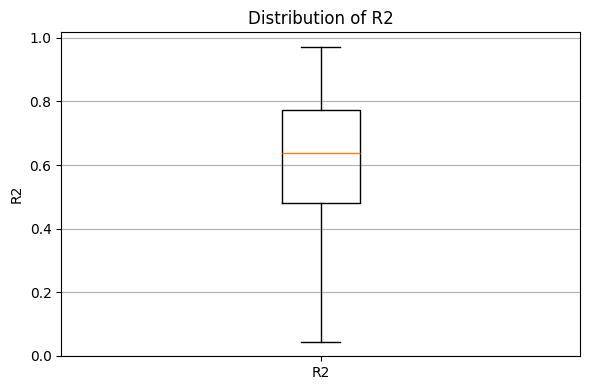

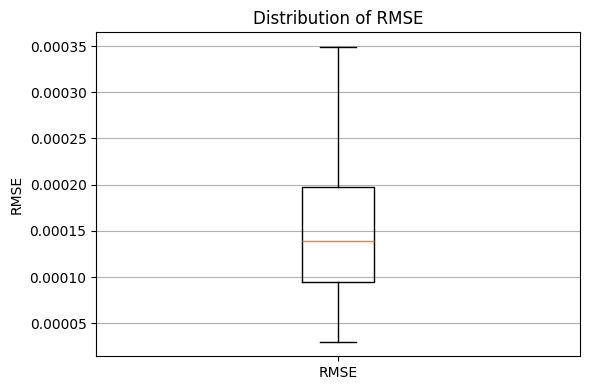

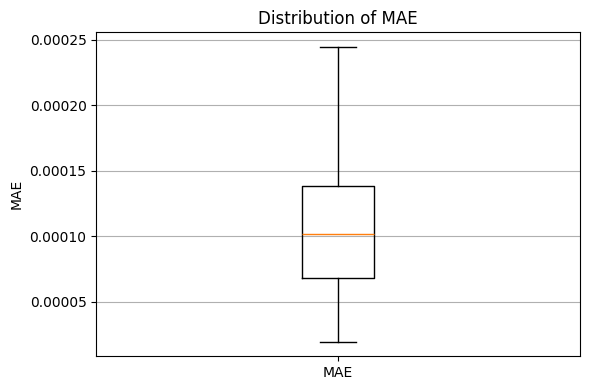

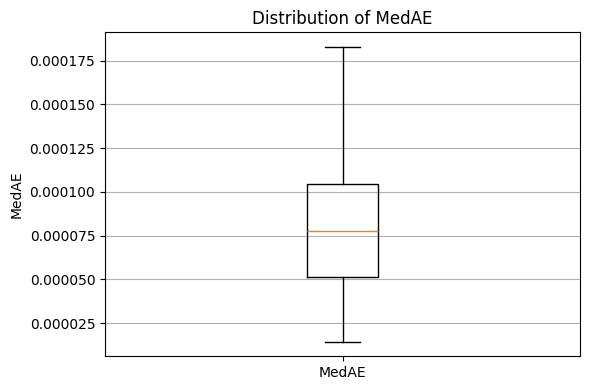

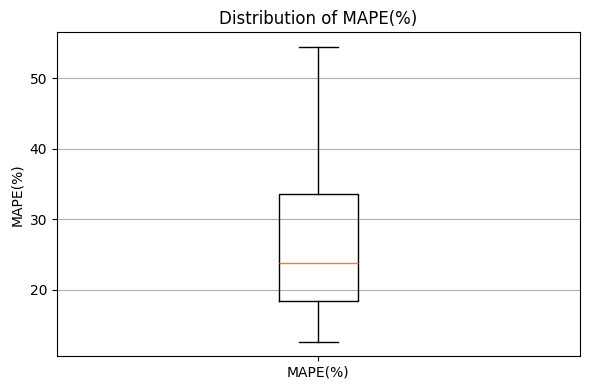

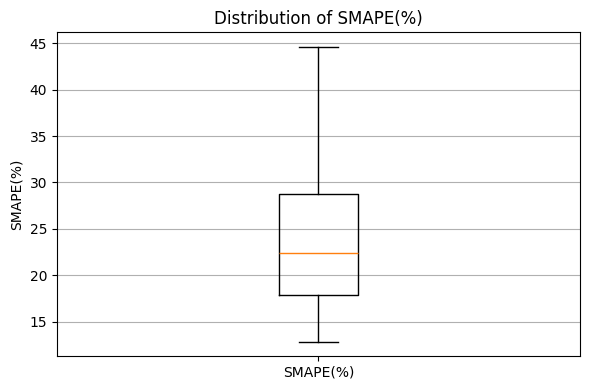

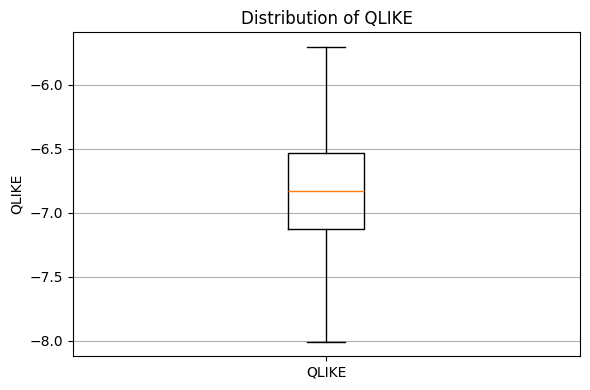

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
metrics_df = pd.read_csv("weekly_metrics(No_cluster)_1.csv")
metric_cols = ["R2", "RMSE", "MAE", "MedAE", "MAPE(%)", "SMAPE(%)", "QLIKE"]
for col in metric_cols:
    values = metrics_df[col].dropna()

    plt.figure(figsize=(6, 4))
    plt.boxplot(values, showfliers=False)
    plt.title(f"Distribution of {col}")
    plt.ylabel(col)
    plt.xticks([1], [col])  
    plt.grid(axis="y")
    plt.tight_layout()
    plt.show()